In [1]:
import optuna
import optuna.visualization as ov
from optuna.samplers import TPESampler
import plotly
import plotly.express as px
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, precision_recall_curve, f1_score, auc
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

/Users/carlachira/anaconda3/envs/ml_env/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv('cleanedData.csv')
data = data.drop("Order", axis = 'columns')
data = data.drop("PID", axis = 'columns')
print(data.shape)
data.head()

(2930, 74)


,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,...,3Ssn Porch,Screen Porch,Fence,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,HasFence
0,20,RL,141.0,31770,1,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,NoFence,0,5,2010,WD,Normal,215000,0
1,20,RH,80.0,11622,1,Reg,Lvl,AllPub,Inside,Gtl,...,0,120,MnPrv,0,6,2010,WD,Normal,105000,1
2,20,RL,81.0,14267,1,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,NoFence,12500,6,2010,WD,Normal,172000,0
3,20,RL,93.0,11160,1,Reg,Lvl,AllPub,Corner,Gtl,...,0,0,NoFence,0,4,2010,WD,Normal,244000,0
4,60,RL,74.0,13830,1,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,MnPrv,0,3,2010,WD,Normal,189900,1


In [3]:
X, y = data.drop("SalePrice", axis = 'columns'), data['SalePrice']
X.head()


,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,...,Enclosed Porch,3Ssn Porch,Screen Porch,Fence,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,HasFence
0,20,RL,141.0,31770,1,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,NoFence,0,5,2010,WD,Normal,0
1,20,RH,80.0,11622,1,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,120,MnPrv,0,6,2010,WD,Normal,1
2,20,RL,81.0,14267,1,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,NoFence,12500,6,2010,WD,Normal,0
3,20,RL,93.0,11160,1,Reg,Lvl,AllPub,Corner,Gtl,...,0,0,0,NoFence,0,4,2010,WD,Normal,0
4,60,RL,74.0,13830,1,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,MnPrv,0,3,2010,WD,Normal,1


In [4]:
y_classesI = pd.cut(
    y,
    bins=10, 
    labels=False, 
    include_lowest=True 
)
print(y_classesI.head())

0    2
1    1
2    2
3    3
4    2
Name: SalePrice, dtype: int64


In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encodedI = le.fit_transform(y_classesI.dropna())


In [6]:
X_numeric = pd.get_dummies(X) 
X_train, X_test, y_train, y_test = train_test_split(
    X_numeric, y_encodedI, test_size=0.1, random_state=42
)

In [7]:
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0)
    }

    model = XGBClassifier(
        **params,
        eval_metric='mlogloss',
        objective='multi:softprob',
        num_class=len(np.unique(y_classesI))
    )

    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)

    f1 = f1_score(y_test, y_pred, average='macro')
    return f1


In [8]:
study = optuna.create_study(direction='maximize', sampler=TPESampler())
study.optimize(objective, n_trials=10)


[I 2025-11-16 19:14:42,376] A new study created in memory with name: no-name-79fab0b5-2b16-46b0-8c52-22b570e7ce51
[I 2025-11-16 19:14:43,992] Trial 0 finished with value: 0.5189425764606419 and parameters: {'max_depth': 8, 'learning_rate': 0.24835562821992332, 'n_estimators': 301, 'subsample': 0.7498916913868962, 'colsample_bytree': 0.7296180261054088, 'gamma': 4.675796946505886, 'reg_alpha': 0.6033898425081502, 'reg_lambda': 0.10167331262234425}. Best is trial 0 with value: 0.5189425764606419.
[I 2025-11-16 19:14:45,444] Trial 1 finished with value: 0.4749689213402506 and parameters: {'max_depth': 7, 'learning_rate': 0.19816606724504623, 'n_estimators': 166, 'subsample': 0.6666487683989157, 'colsample_bytree': 0.6506397984726292, 'gamma': 0.3325993303957825, 'reg_alpha': 0.820303815009869, 'reg_lambda': 0.7065011188086993}. Best is trial 0 with value: 0.5189425764606419.
[I 2025-11-16 19:14:47,970] Trial 2 finished with value: 0.4802172947717722 and parameters: {'max_depth': 12, 'lear

In [9]:
best_trial = study.best_trial
print("Best Macro F1:", best_trial.value)
print("Best hyperparameters:", best_trial.params)


Best Macro F1: 0.5442388298332037
Best hyperparameters: {'max_depth': 7, 'learning_rate': 0.10678527587753849, 'n_estimators': 669, 'subsample': 0.7046938683895314, 'colsample_bytree': 0.8070051602361836, 'gamma': 4.197986166310409, 'reg_alpha': 0.4388968703639323, 'reg_lambda': 0.0888985882008706}


In [10]:
import nbformat
ov.plot_optimization_history(study).show()
ov.plot_param_importances(study).show()

In [11]:
best_params = best_trial.params
final_model = XGBClassifier(
    **best_params,
    eval_metric='mlogloss',
    objective='multi:softprob',
    num_class=len(np.unique(y_classesI))
)

final_model.fit(X_train, y_train)


,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8070051602361836
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [12]:
from sklearn.metrics import accuracy_score, classification_report
import sklearn
y_predI = final_model.predict(X_test)
y_probI = final_model.predict_proba(X_test)

print("\n Accuracy:", accuracy_score(y_test, y_predI))

print("\n f1 score: ", sklearn.metrics.f1_score(y_test, y_predI, average='weighted'))

print("\n Precision:", sklearn.metrics.precision_score(y_test, y_predI, average='weighted', zero_division=0))

print("\n Recall", sklearn.metrics.recall_score(y_test, y_predI, average='weighted', zero_division=0))

print("\n Predicted class labels:", y_predI[:5])
print(" Actual class labels   :", y_test[:5])


 Accuracy: 0.8191126279863481

 f1 score:  0.8130300153113158

 Precision: 0.8075358449750969

 Recall 0.8191126279863481

 Predicted class labels: [1 1 2 1 1]
 Actual class labels   : [1 1 2 1 1]


In [13]:
study = optuna.create_study(direction='maximize', sampler=TPESampler())
study.optimize(objective, n_trials=50)


[I 2025-11-16 19:16:11,674] A new study created in memory with name: no-name-1ad9b589-da8c-46cf-a70c-16ffbb80d8b8
[I 2025-11-16 19:16:12,940] Trial 0 finished with value: 0.5127272923045599 and parameters: {'max_depth': 9, 'learning_rate': 0.22246678196167302, 'n_estimators': 176, 'subsample': 0.6439511815368633, 'colsample_bytree': 0.7400720279349493, 'gamma': 4.13128118225778, 'reg_alpha': 0.6391619549638208, 'reg_lambda': 0.35476700770155056}. Best is trial 0 with value: 0.5127272923045599.
[I 2025-11-16 19:16:16,884] Trial 1 finished with value: 0.47804512162983337 and parameters: {'max_depth': 4, 'learning_rate': 0.12503019111417887, 'n_estimators': 664, 'subsample': 0.992814460291044, 'colsample_bytree': 0.7732029260741666, 'gamma': 0.20379614410553637, 'reg_alpha': 0.9146746539156608, 'reg_lambda': 0.4324199674614979}. Best is trial 0 with value: 0.5127272923045599.
[I 2025-11-16 19:16:19,388] Trial 2 finished with value: 0.530783709292949 and parameters: {'max_depth': 4, 'learn

In [14]:
best_trial = study.best_trial
print("Best Macro F1:", best_trial.value)
print("Best hyperparameters:", best_trial.params)


Best Macro F1: 0.5584454439178003
Best hyperparameters: {'max_depth': 7, 'learning_rate': 0.15045578937685403, 'n_estimators': 237, 'subsample': 0.792564660755943, 'colsample_bytree': 0.7059649396646367, 'gamma': 4.632287975557202, 'reg_alpha': 0.16556214164542382, 'reg_lambda': 0.741583187685665}


In [15]:
ov.plot_optimization_history(study).show()
ov.plot_param_importances(study).show()

In [16]:
best_params = best_trial.params
final_model = XGBClassifier(
    **best_params,
    eval_metric='mlogloss',
    objective='multi:softprob',
    num_class=len(np.unique(y_classesI))
)

final_model.fit(X_train, y_train)


,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.7059649396646367
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [17]:
from sklearn.metrics import accuracy_score, classification_report
import sklearn
y_predI = final_model.predict(X_test)
y_probI = final_model.predict_proba(X_test)

print("\n Accuracy:", accuracy_score(y_test, y_predI))

print("\n f1 score: ", sklearn.metrics.f1_score(y_test, y_predI, average='weighted'))

print("\n Precision:", sklearn.metrics.precision_score(y_test, y_predI, average='weighted', zero_division=0))

print("\n Recall", sklearn.metrics.recall_score(y_test, y_predI, average='weighted', zero_division=0))

print("\n Predicted class labels:", y_predI[:5])
print(" Actual class labels   :", y_test[:5])


 Accuracy: 0.8225255972696246

 f1 score:  0.8148803058060744

 Precision: 0.8092808500581399

 Recall 0.8225255972696246

 Predicted class labels: [1 1 2 1 1]
 Actual class labels   : [1 1 2 1 1]


In [18]:
study30 = optuna.create_study(direction='maximize', sampler=TPESampler())
study30.optimize(objective, n_trials=30)

[I 2025-11-16 19:20:31,766] A new study created in memory with name: no-name-2350420e-565b-4364-9914-6e5ab035fc4a
[I 2025-11-16 19:20:33,689] Trial 0 finished with value: 0.4748422193546557 and parameters: {'max_depth': 4, 'learning_rate': 0.2912883535301149, 'n_estimators': 356, 'subsample': 0.5863442909593497, 'colsample_bytree': 0.7954554755688721, 'gamma': 2.1918092388993795, 'reg_alpha': 0.7690223315927228, 'reg_lambda': 0.059161468424455355}. Best is trial 0 with value: 0.4748422193546557.
[I 2025-11-16 19:20:35,041] Trial 1 finished with value: 0.48036185438586565 and parameters: {'max_depth': 10, 'learning_rate': 0.2904397596155208, 'n_estimators': 237, 'subsample': 0.5639949162448881, 'colsample_bytree': 0.912906901322327, 'gamma': 1.8361269130194584, 'reg_alpha': 0.3138039945152211, 'reg_lambda': 0.10354413141871899}. Best is trial 1 with value: 0.48036185438586565.
[I 2025-11-16 19:20:39,304] Trial 2 finished with value: 0.46002870000028806 and parameters: {'max_depth': 4, '

In [19]:
best_trial30 = study30.best_trial
print("Best Macro F1:", best_trial30.value)
print("Best hyperparameters:", best_trial30.params)

Best Macro F1: 0.5429018954526029
Best hyperparameters: {'max_depth': 4, 'learning_rate': 0.2887893773347632, 'n_estimators': 952, 'subsample': 0.6884359647217402, 'colsample_bytree': 0.8068967136744284, 'gamma': 3.561376345575318, 'reg_alpha': 0.3670528146069556, 'reg_lambda': 0.607460168617283}


In [20]:
best_params30 = best_trial30.params
final_model30 = XGBClassifier(
    **best_params,
    eval_metric='mlogloss',
    objective='multi:softprob',
    num_class=len(np.unique(y_classesI))
)

final_model30.fit(X_train, y_train)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.7059649396646367
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [21]:
from sklearn.metrics import accuracy_score, classification_report
import sklearn
y_predI30 = final_model30.predict(X_test)
y_probI30 = final_model30.predict_proba(X_test)

print("\n Accuracy:", accuracy_score(y_test, y_predI30))

print("\n f1 score: ", sklearn.metrics.f1_score(y_test, y_predI30, average='weighted'))

print("\n Precision:", sklearn.metrics.precision_score(y_test, y_predI30, average='weighted', zero_division=0))

print("\n Recall", sklearn.metrics.recall_score(y_test, y_predI30, average='weighted', zero_division=0))

print("\n Predicted class labels:", y_predI30[:5])
print(" Actual class labels   :", y_test[:5])


 Accuracy: 0.8225255972696246

 f1 score:  0.8148803058060744

 Precision: 0.8092808500581399

 Recall 0.8225255972696246

 Predicted class labels: [1 1 2 1 1]
 Actual class labels   : [1 1 2 1 1]


ROC Curve for Multi-Class XGBoost

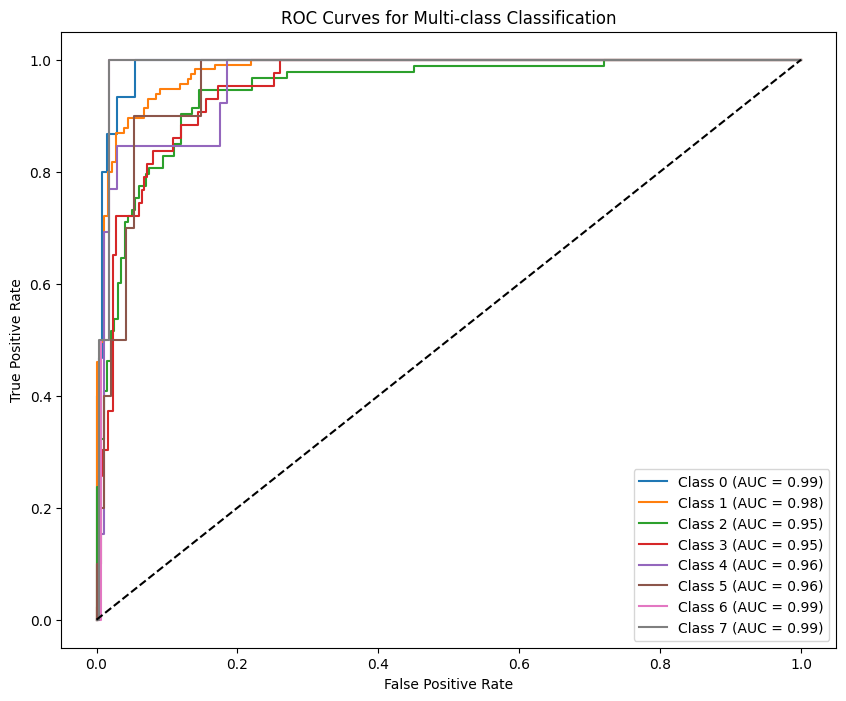

In [22]:
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_probI[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multi-class Classification')
plt.legend(loc='lower right')
plt.show()

In [23]:
best_treshold = {}
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

for i in range(n_classes):
    fpr, tpr, thresholds = roc_curve(y_test_bin[:, i], y_probI[:, i])
    j_scores = tpr - fpr
    best_threshold_index = np.argmax(j_scores)

    best_treshold[i] = {
        'threshold': thresholds[best_threshold_index],
        'tpr': tpr[best_threshold_index],
        'fpr': fpr[best_threshold_index]
    }

print("Best thresholds for each class:")
for cls, vals in best_treshold.items():
    print(f"Class {cls}: Threshold = {vals['threshold']:.4f}, TPR = {vals['tpr']:.4f}, FPR = {vals['fpr']:.4f}")

Best thresholds for each class:
Class 0: Threshold = 0.0826, TPR = 1.0000, FPR = 0.0540
Class 1: Threshold = 0.4521, TPR = 0.9478, FPR = 0.0899
Class 2: Threshold = 0.2652, TPR = 0.9462, FPR = 0.1450
Class 3: Threshold = 0.0987, TPR = 0.9535, FPR = 0.1720
Class 4: Threshold = 0.3709, TPR = 0.8462, FPR = 0.0286
Class 5: Threshold = 0.0119, TPR = 1.0000, FPR = 0.1484
Class 6: Threshold = 0.0600, TPR = 1.0000, FPR = 0.0172
Class 7: Threshold = 0.0227, TPR = 1.0000, FPR = 0.0172


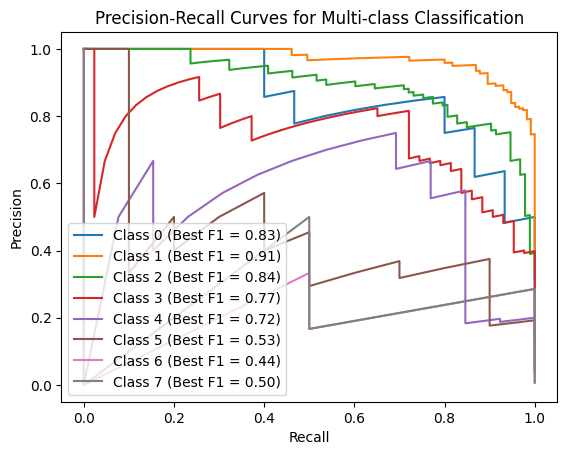

Best PR thresholds per class: {0: np.float32(0.5141199), 1: np.float32(0.5805671), 2: np.float32(0.26519498), 3: np.float32(0.45534956), 4: np.float32(0.46220502), 5: np.float32(0.030852161), 6: np.float32(0.06002209), 7: np.float32(0.065804526)}


In [24]:
from sklearn.metrics import precision_recall_curve

best_pr_thresholds = {}
n_classes = y_test_bin.shape[1]

plt.figure()
for i in range(n_classes):
    precision, recall, thresholds = precision_recall_curve(y_test_bin[:, i], y_probI[:, i])
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    best_idx = np.argmax(f1_scores)
    best_pr_thresholds[i] = thresholds[best_idx] if best_idx < len(thresholds) else 0.5
    plt.plot(recall, precision, label=f'Class {i} (Best F1 = {f1_scores[best_idx]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Multi-class Classification')
plt.legend()
plt.show()
print("Best PR thresholds per class:", best_pr_thresholds)


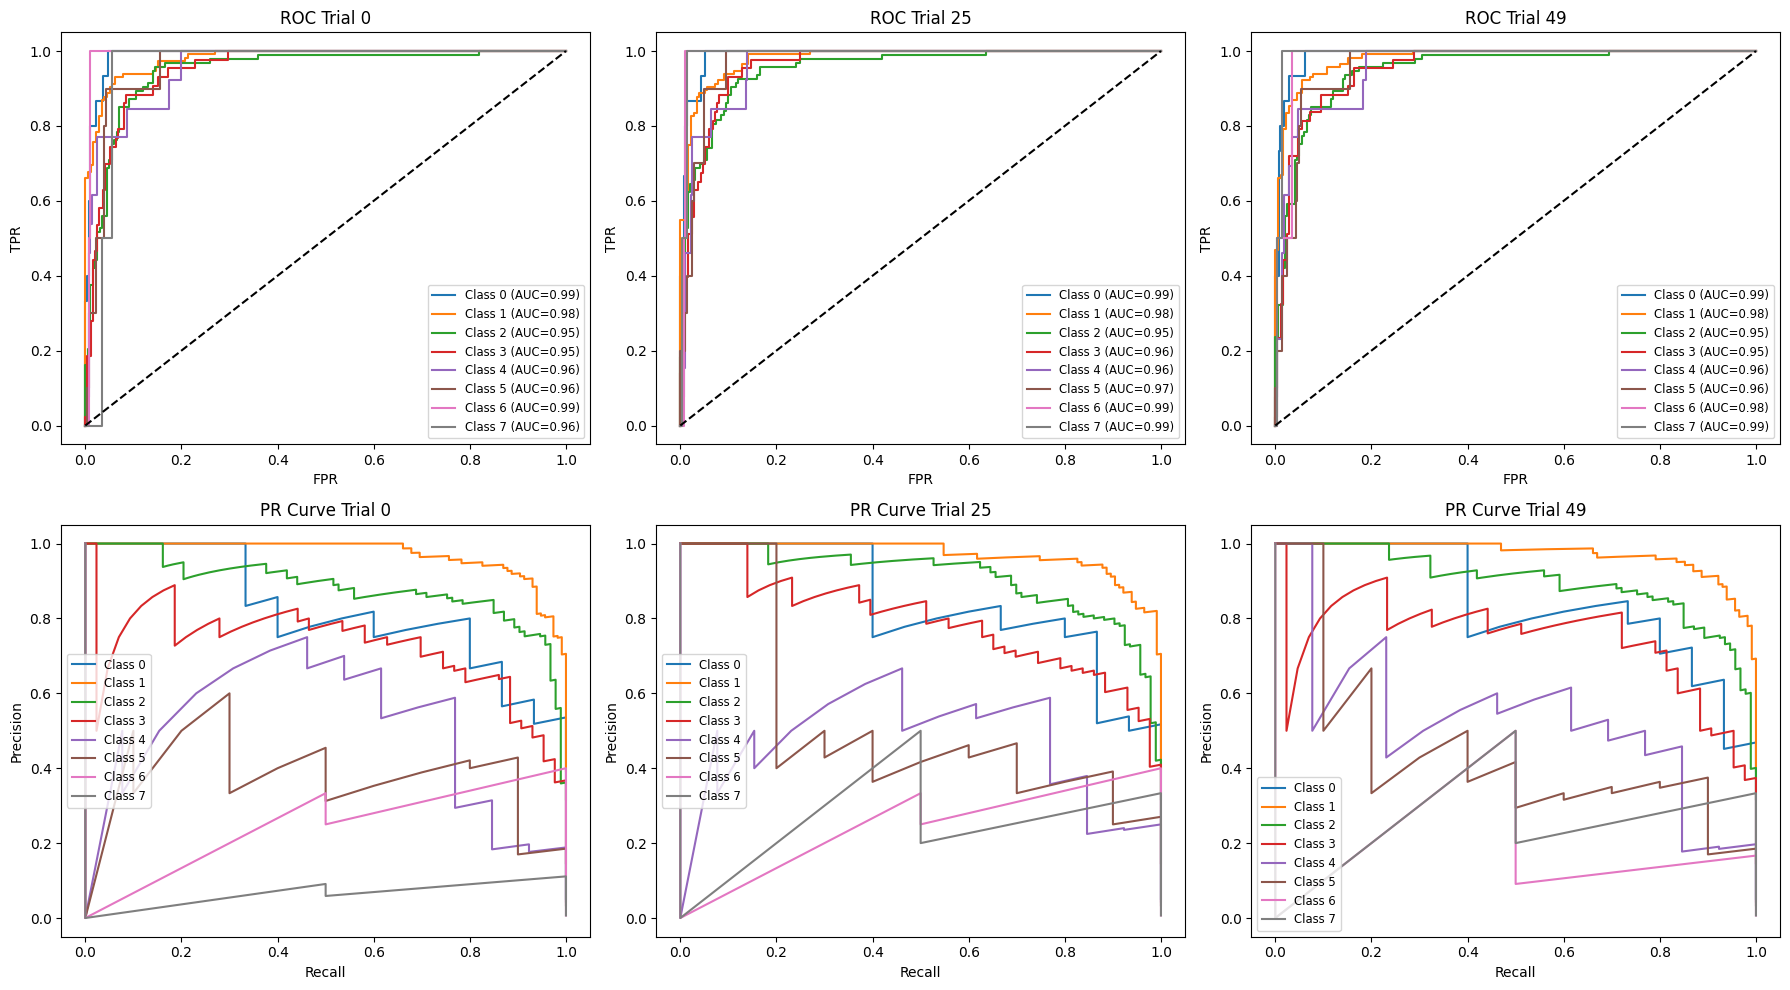

In [25]:
n_classes = y_test_bin.shape[1]
iteration_indices = [0, len(study.trials)//2, len(study.trials)-1]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for col_idx, trial_idx in enumerate(iteration_indices):
    trial_params = study.trials[trial_idx].params
    iter_model = XGBClassifier(
        **trial_params,
        eval_metric='mlogloss',
        objective='multi:softprob',
        num_class=n_classes
    )
    iter_model.fit(X_train, y_train)
    y_prob_iter = iter_model.predict_proba(X_test)
    
    # ROC Curve
    ax_roc = axes[0, col_idx]
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob_iter[:, i])
        roc_auc = auc(fpr, tpr)
        ax_roc.plot(fpr, tpr, label=f'Class {i} (AUC={roc_auc:.2f})')
    ax_roc.plot([0, 1], [0, 1], 'k--')
    ax_roc.set_title(f'ROC Trial {trial_idx}')
    ax_roc.set_xlabel('FPR')
    ax_roc.set_ylabel('TPR')
    ax_roc.legend(fontsize='small')

    # Precision-Recall Curve
    ax_pr = axes[1, col_idx]
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_prob_iter[:, i])
        ax_pr.plot(recall, precision, label=f'Class {i}')
    ax_pr.set_title(f'PR Curve Trial {trial_idx}')
    ax_pr.set_xlabel('Recall')
    ax_pr.set_ylabel('Precision')
    ax_pr.legend(fontsize='small')

plt.tight_layout()
plt.show()


In [ ]:
yD = data["SalePrice"]#dezechilibru

n_classes = 10
min_val, max_val = yD.min(), yD.max()
internal_edges = np.linspace(min_val, max_val, n_classes - 2)  
internal_edges = internal_edges[1:-1] 
bins = [-np.inf] + internal_edges.tolist() + [np.inf]

y_classD = pd.cut(y, bins=bins, labels=False)
y_classD

0       1
1       0
2       1
3       2
4       1
       ..
2925    1
2926    1
2927    1
2928    1
2929    1
Name: SalePrice, Length: 2930, dtype: int64

In [27]:
Xd = data.drop(columns=["SalePrice"])
Xd = pd.get_dummies(Xd)
X_trainD, X_testD, y_trainD, y_testD = train_test_split(
    Xd, y_classD,                      # <- actual regression target or same y
    stratify=y_classD,          # <- temporary labels used ONLY for stratification
    test_size=0.1,
    random_state=42
)

In [28]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_classD),
    y=y_classD
)

In [29]:
def objectiveD(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0)
    }

    model = XGBClassifier(
        **params,
        eval_metric='mlogloss',
        objective='multi:softprob',
        num_class=len(np.unique(y_classD))
    )

    model.fit(X_trainD, y_trainD)
    y_pred_probaD = model.predict_proba(X_testD)
    y_predD = np.argmax(y_pred_probaD, axis=1)

    f1 = f1_score(y_testD, y_predD, average='macro')
    return f1


In [30]:
studyD = optuna.create_study(direction='maximize', sampler=TPESampler())
studyD.optimize(objectiveD, n_trials=50)

[I 2025-11-16 19:23:46,962] A new study created in memory with name: no-name-0032c9a1-b636-4767-be7d-7054a696f5f1
[I 2025-11-16 19:23:50,646] Trial 0 finished with value: 0.5698081346816793 and parameters: {'max_depth': 4, 'learning_rate': 0.17073912709075978, 'n_estimators': 996, 'subsample': 0.6944298308896254, 'colsample_bytree': 0.8719379676424939, 'gamma': 2.974237008460025, 'reg_alpha': 0.30335370052716093, 'reg_lambda': 0.5672612347339318}. Best is trial 0 with value: 0.5698081346816793.
[I 2025-11-16 19:23:52,305] Trial 1 finished with value: 0.6217370799603027 and parameters: {'max_depth': 3, 'learning_rate': 0.10225807751169154, 'n_estimators': 377, 'subsample': 0.8414836137555732, 'colsample_bytree': 0.8807594095958322, 'gamma': 2.1297328496543506, 'reg_alpha': 0.9042697569716748, 'reg_lambda': 0.20228105852560474}. Best is trial 1 with value: 0.6217370799603027.
[I 2025-11-16 19:23:55,829] Trial 2 finished with value: 0.5609793726945776 and parameters: {'max_depth': 10, 'le

In [31]:
best_trialD = studyD.best_trial
print("Best Macro F1:", best_trialD.value)
print("Best hyperparameters:", best_trialD.params)

Best Macro F1: 0.6384125957465909
Best hyperparameters: {'max_depth': 10, 'learning_rate': 0.20267816624201446, 'n_estimators': 498, 'subsample': 0.789991257104639, 'colsample_bytree': 0.7754056336713944, 'gamma': 1.6289553681700069, 'reg_alpha': 0.11221839010934986, 'reg_lambda': 0.7963685928713418}


In [32]:
best_paramsD = best_trialD.params
final_modelD = XGBClassifier(
    **best_params,
    eval_metric='mlogloss',
    objective='multi:softprob',
    num_class=len(np.unique(y_classD))
)

final_modelD.fit(X_trainD, y_trainD)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.7059649396646367
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [33]:
from sklearn.metrics import accuracy_score, classification_report
import sklearn
y_predD = final_modelD.predict(X_testD)
y_probD = final_modelD.predict_proba(X_testD)

print("\n Accuracy:", accuracy_score(y_testD, y_predD))

print("\n f1 score: ", sklearn.metrics.f1_score(y_testD, y_predD, average='weighted'))

print("\n Precision:", sklearn.metrics.precision_score(y_testD, y_predD, average='weighted', zero_division=0))

print("\n Recall", sklearn.metrics.recall_score(y_testD, y_predD, average='weighted', zero_division=0))

print("\n Predicted class labels:", y_predD[:5])
print(" Actual class labels   :", y_testD[:5])


 Accuracy: 0.8122866894197952

 f1 score:  0.8030396071334899

 Precision: 0.7997441324087458

 Recall 0.8122866894197952

 Predicted class labels: [1 1 1 1 2]
 Actual class labels   : 1525    1
2783    1
1376    1
236     1
1703    2
Name: SalePrice, dtype: int64


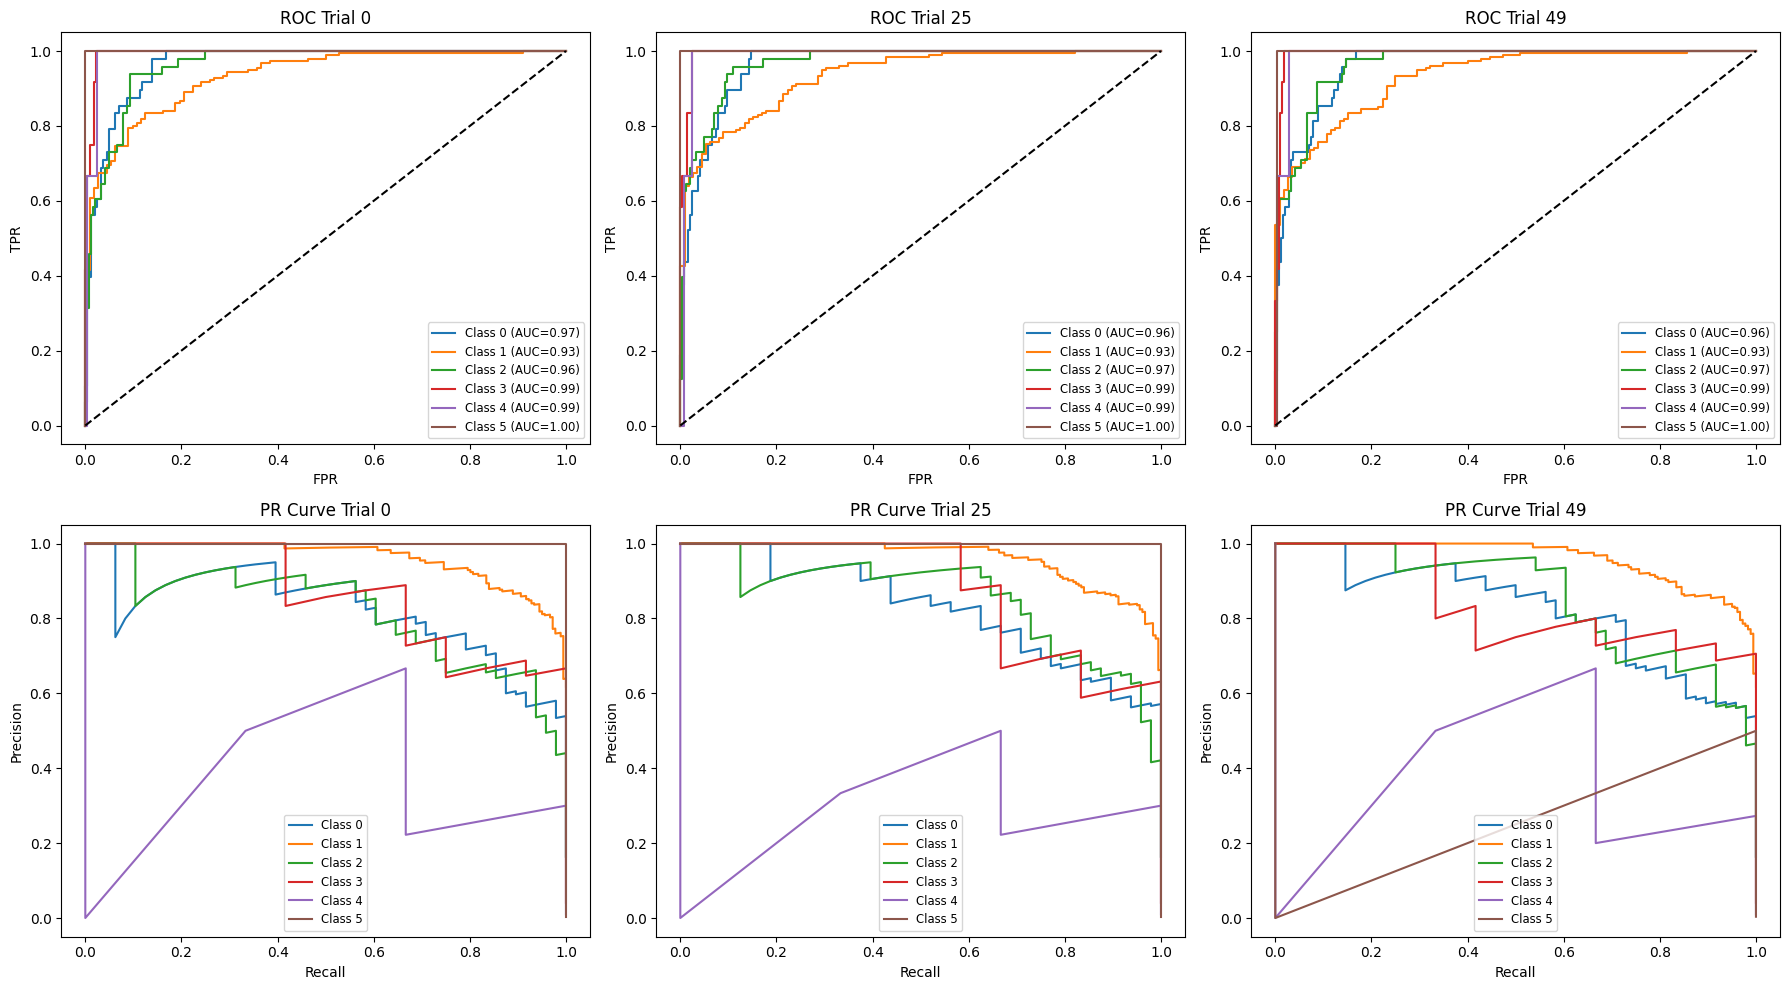

In [38]:
y_testD_bin = label_binarize(y_testD, classes=np.unique(y_testD))
n_classesD = y_testD_bin.shape[1]
iteration_indicesD = [0, len(studyD.trials)//2, len(studyD.trials)-1]

figD, axesD = plt.subplots(2, 3, figsize=(18, 10))

for col_idx, trial_idx in enumerate(iteration_indicesD):
    trial_params = studyD.trials[trial_idx].params
    iter_model = XGBClassifier(
        **trial_params,
        eval_metric='mlogloss',
        objective='multi:softprob',
        num_class=n_classesD
    )
    iter_model.fit(X_trainD, y_trainD)
    y_prob_iter = iter_model.predict_proba(X_testD)
    
    # ROC Curve
    ax_roc = axesD[0, col_idx]
    for i in range(n_classesD):
        fpr, tpr, _ = roc_curve(y_testD_bin[:, i], y_prob_iter[:, i])
        roc_auc = auc(fpr, tpr)
        ax_roc.plot(fpr, tpr, label=f'Class {i} (AUC={roc_auc:.2f})')
    ax_roc.plot([0, 1], [0, 1], 'k--')
    ax_roc.set_title(f'ROC Trial {trial_idx}')
    ax_roc.set_xlabel('FPR')
    ax_roc.set_ylabel('TPR')
    ax_roc.legend(fontsize='small')

    # Precision-Recall Curve
    ax_pr = axesD[1, col_idx]
    for i in range(n_classesD):
        precision, recall, _ = precision_recall_curve(y_testD_bin[:, i], y_prob_iter[:, i])
        ax_pr.plot(recall, precision, label=f'Class {i}')
    ax_pr.set_title(f'PR Curve Trial {trial_idx}')
    ax_pr.set_xlabel('Recall')
    ax_pr.set_ylabel('Precision')
    ax_pr.legend(fontsize='small')

plt.tight_layout()
plt.show()
